# Setup

**Imports**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw
from sklearn.neighbors import KNeighborsClassifier
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



**Utility functions**

In [4]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

(100, 200)
(100, 500)
(100, 1000)


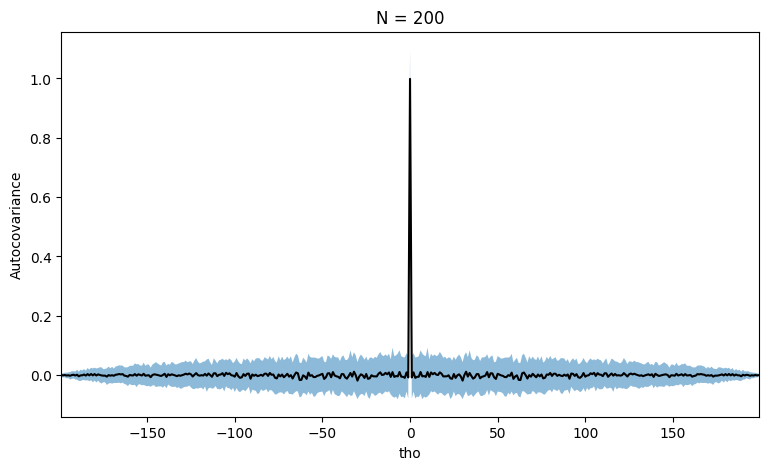

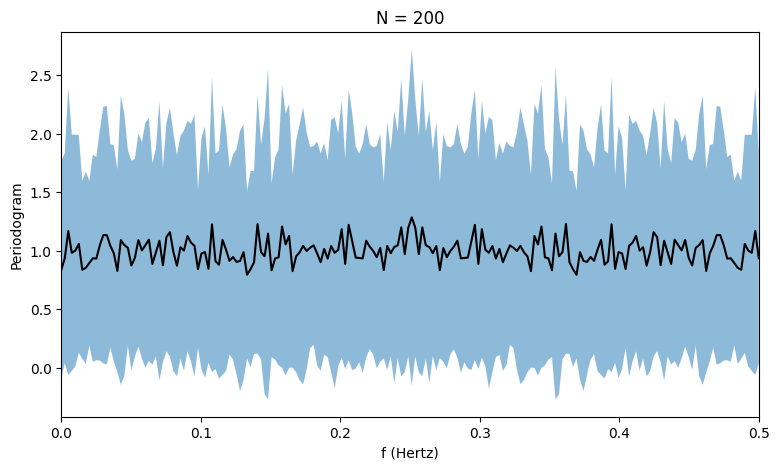

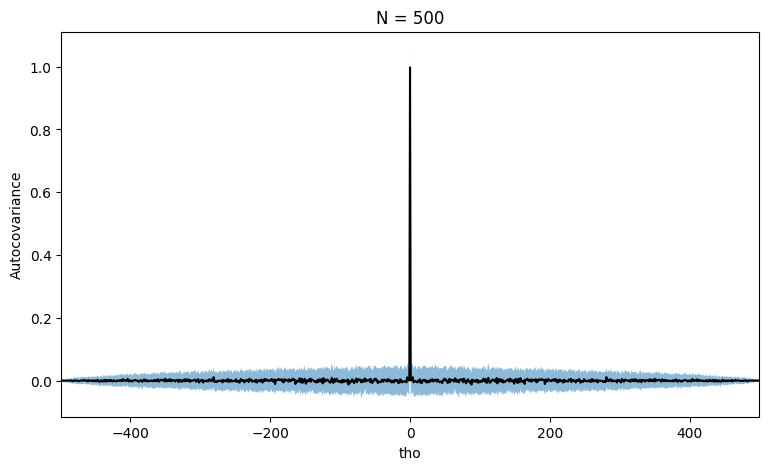

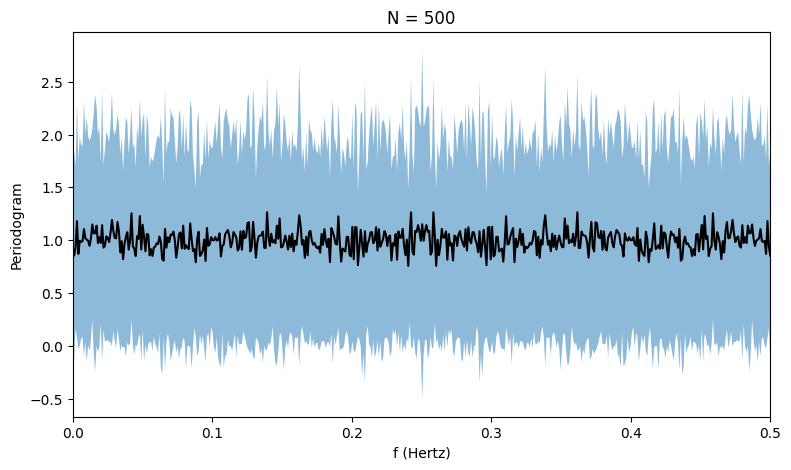

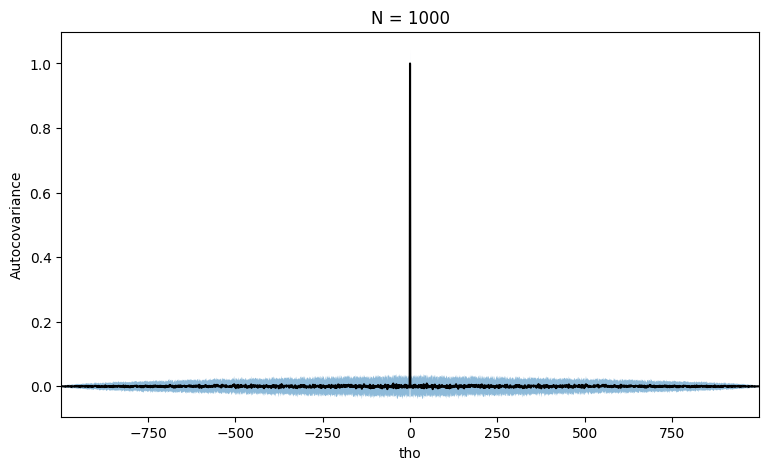

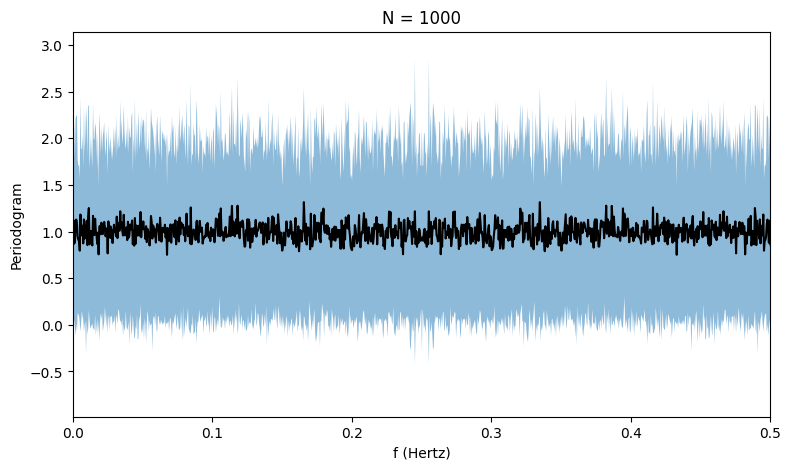

In [5]:
def computation(N):
    X_n = np.random.randn(100, N)
    auto_conv = np.array([np.correlate(x_n, x_n, mode='full')/N for x_n in X_n]) # sample following equatioon (6)
    periodogram = np.array([np.abs(np.fft.fft(x_n)/np.sqrt(N))**2 for x_n in X_n]) # periodogram following equation (7)
    print(periodogram.shape)
    return auto_conv, periodogram

N_array = [200, 500, 1000]
for N in N_array:
    auto_cov, periodograms = computation(N)
    taus = np.linspace(-(N-1), (N-1), 2*N-1)
    avg = auto_cov.mean(axis=0)
    std = auto_cov.std(axis=0)
    fig, ax = fig_ax(figsize=(9, 5))
    ax.set_title(f'N = {N}')
    ax.set_xlabel('tho')
    ax.set_ylabel('Autocovariance')
    ax.plot(taus, avg, 'k-')
    ax.fill_between(taus, avg-std, avg+std, alpha=0.5)
    fig.savefig(f'./figuresQ6_auto_cov{N}.png')


    freqs = np.linspace(0, 0.5, N)
    avg = periodograms.mean(axis=0)
    std = periodograms.std(axis=0)
    fig, ax = fig_ax(figsize=(9, 5))
    ax.set_title(f'N = {N}')
    ax.set_xlabel('f (Hertz)')
    ax.set_ylabel('Periodogram')
    ax.plot(freqs, avg, 'k-')
    ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)
    fig.savefig(f'./figuresQ6_periodogram{N}.png')

## Question 9

(100, 40)
(100, 100)
(100, 200)


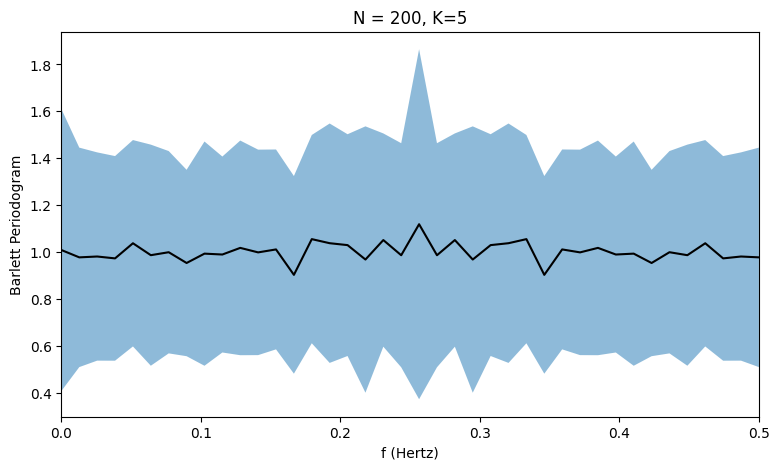

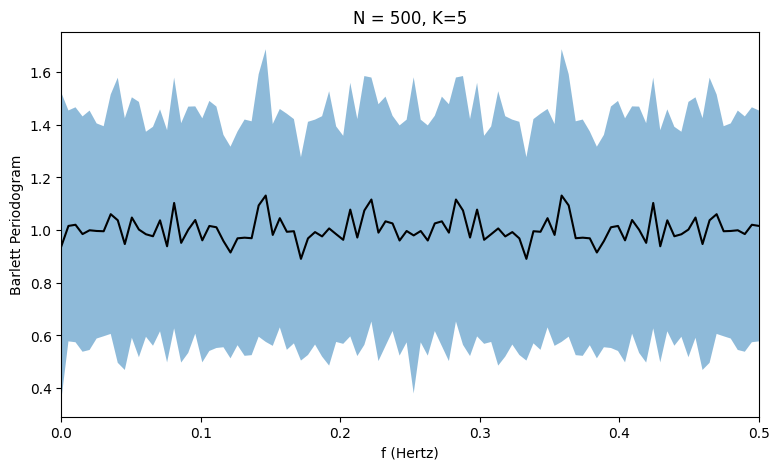

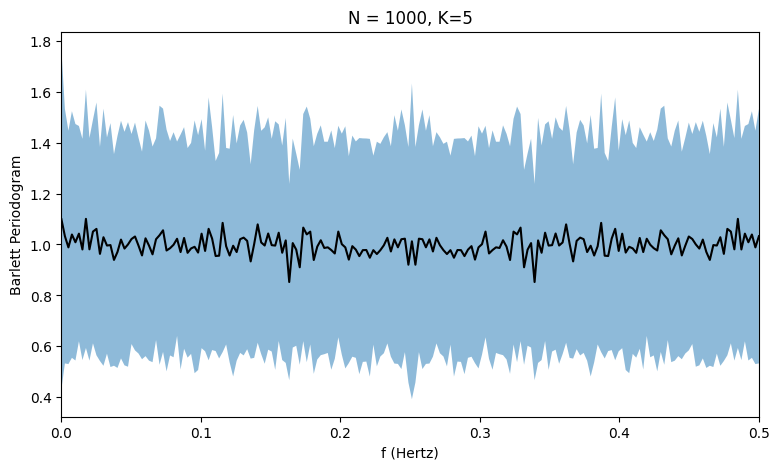

In [6]:
def Bartlett_periodogram(N, K):
    X_n = np.random.randn(100, N)
    sample_size = N//K
    barlett_periodogram = []
    for x_simu in X_n:
        periodogram_simu = np.array([np.abs(np.fft.fft(x_simu[i*sample_size:(i+1)*sample_size])/np.sqrt(sample_size))**2 for i in range(K)]).mean(axis=0)
        barlett_periodogram.append(periodogram_simu)
    print(np.array(barlett_periodogram).shape)
    return np.array(barlett_periodogram)

N_array = [200, 500, 1000]
K=5
for N in N_array:
    barlett_periodogram = Bartlett_periodogram(N, K)
    freqs = np.linspace(0, 0.5, N//K)
    avg = barlett_periodogram.mean(axis=0)
    std = barlett_periodogram.std(axis=0)

    fig, ax = fig_ax(figsize=(9, 5))
    ax.set_title(f'N = {N}, K={K}')
    ax.set_xlabel('f (Hertz)')
    ax.set_ylabel('Barlett Periodogram')
    ax.plot(freqs, avg, 'k-')
    ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)
    fig.savefig(f'./figuresQ9_periodogram{N}.png')

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [7]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)


X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

100%|██████████| 202M/202M [00:20<00:00, 9.72MiB/s]


## Question 10

In [8]:
# data normalization
for index in range(len(X_train)):
    x = np.array(X_train[index])
    mean = sum(x) / len(x)
    standard_deviation = np.sqrt( sum( (x - mean)**2 ) / len(x))
    X_train[index] = (x - mean) / standard_deviation
for index in range(len(X_test)):
    x = np.array(X_test[index])
    mean = sum(x) / len(x)
    standard_deviation = np.sqrt( sum( (x - mean)**2 ) / len(x))
    X_test[index] = (x - mean) / standard_deviation

In [9]:
k_values = [1, 3, 5, 7, 9]
best_score, best_k = 0,0

X_train_matrix = np.zeros((len(X_train),len(X_train)))
for i in range(len(X_train)):
    for j in range(len(X_train)):
        X_train_matrix[i,j] = dtw(X_train[i], X_train[j]).distance

X_test_matrix = np.zeros((len(X_test),len(X_train)))
for i in range(len(X_test)):
    for j in range(len(X_train)):
        X_test_matrix[i,j] = dtw(X_test[i], X_train[j]).distance

print("score for KNeighborsClassifier with")

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed")
    knn.fit(X_train_matrix, y_train)
    score = knn.score(X_test_matrix, y_test).mean()
    print(f"\t{k} neighbors: {score}")
    if score > best_score:
        best_score=score
        best_k = k
        best_knn = knn

print(f"Optimal number of neighbor(s): {best_k}")
print(f"Associated F-score: {best_score}")

score for KNeighborsClassifier with
	1 neighbors: 0.3977272727272727
	3 neighbors: 0.3409090909090909
	5 neighbors: 0.3068181818181818
	7 neighbors: 0.32954545454545453
	9 neighbors: 0.3522727272727273
Optimal number of neighbor(s): 1
Associated F-score: 0.3977272727272727


## Question 11

<Figure size 640x480 with 0 Axes>

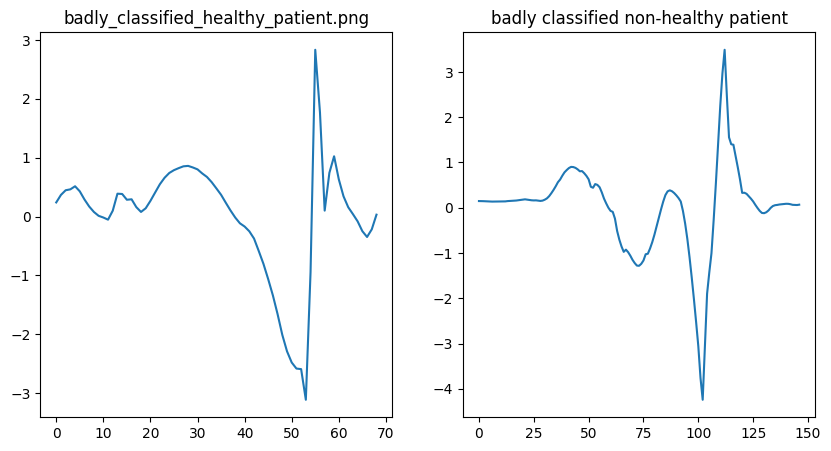

In [10]:
y_pred = best_knn.predict(X_test_matrix)

bad_healthy_pred = next((i for i, (pred, true) in enumerate(zip(y_pred, y_test)) if pred != true and true == 0), None) # first bad prediction for an healthy patient
bad_non_healthy_pred = next((i for i, (pred, true) in enumerate(zip(y_pred, y_test)) if pred != true and true == 1), None) # first bad prediction for a non-healthy patient


plt.plot(X_test[bad_healthy_pred])
plt.savefig('figuresQ11_badly_classified_healthy_patient.png')
plt.clf()
plt.plot(X_test[bad_non_healthy_pred])
plt.savefig('figuresQ11_badly_classified_non_healthy_patient.png')
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(X_test[bad_healthy_pred])
ax1.set_title('badly_classified_healthy_patient.png')
ax2.plot(X_test[bad_non_healthy_pred])
ax2.set_title('badly classified non-healthy patient')
plt.show()